In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
status_dir = "../../Data/filtered_status.csv"
status_df = pd.read_csv(status_dir, parse_dates=['time'])

In [19]:
status_df[status_df.station_id==8]#.dropna()

,station_id,bikes_available,docks_available,time
6282522,8,8,7,2013-08-29 12:06:01
6282523,8,8,7,2013-08-29 12:07:01
6282524,8,8,7,2013-08-29 12:08:01
6282525,8,8,7,2013-08-29 12:09:01
6282526,8,8,7,2013-08-29 12:10:01
...,...,...,...,...
7329060,8,13,2,2015-08-31 23:55:02
7329061,8,13,2,2015-08-31 23:56:01
7329062,8,13,2,2015-08-31 23:57:02
7329063,8,13,2,2015-08-31 23:58:02


In [15]:
intervals = [5, 10, 20, 60] # interval in minutes
stationIDs = [70, 34, 72, 69, 73, 84] # arbitrary set of station IDs

for stationID in stationIDs:
    interval_status_df = status_df[status_df.station_id==stationID].drop('station_id', axis=1)
    for interval in intervals:
        # calculate the total number of bikes in each interval
        interval_status_df = interval_status_df.resample(f"{interval}T", on = 'time').sum().reset_index()

        # calculate the variation of the total number of bikes
        delta_df = pd.DataFrame()
        delta_df['time'] = interval_status_df['time'].shift(-1)
        delta_df['delta_bikes'] = (interval_status_df['bikes_available'].shift(-1) - interval_status_df['bikes_available'])
        delta_df.dropna(inplace=True)

        # group by interval, discarding the day
        delta_df['day_time'] = delta_df['time'].dt.time
        delta_df.drop('time', axis=1, inplace=True)
        grouped_df = delta_df.groupby('day_time').mean().reset_index()
        grouped_df['sum_deltas'] = np.cumsum(grouped_df.delta_bikes)

        # plot and save
        grouped_df.day_time = grouped_df.day_time.astype(str)

        plt.figure(figsize=(10,6))
        sns.lineplot(x='day_time', y='value', hue='variable', data=pd.melt(grouped_df, ['day_time']))
        plt.xticks(
            grouped_df['day_time'].iloc[::int(60/interval)],
            rotation=45,
            horizontalalignment='right',
            fontweight='light'
        )
        plt.ylabel('Bikes')
        plt.xlabel('Time')
        if not os.path.exists(f"../../Results/Variations/Station_{stationID}/"):
            os.makedirs(f"../../Results/Variations/Station_{stationID}/")
        plt.savefig(f"../../Results/Variations/Station_{stationID}/Interval_{interval}.jpg", bbox_inches='tight')
        plt.close()

In [36]:
# plot variations with sum and without day averaging
intervals = [5, 10, 20, 60] # interval in minutes
stationIDs = [70, 34, 72, 69, 73, 84] # arbitrary set of station IDs

for stationID in stationIDs:
    interval_status_df = status_df[status_df.station_id==stationID].drop('station_id', axis=1)
    for interval in intervals:
        # calculate the total number of bikes in each interval
        interval_status_df = interval_status_df.resample(f"{interval}T", on = 'time').mean().reset_index()

        # calculate the variation of the total number of bikes
        delta_df = pd.DataFrame()
        delta_df['time'] = interval_status_df['time'].shift(-1)
        delta_df['delta_bikes'] = (interval_status_df['bikes_available'].shift(-1) - interval_status_df['bikes_available'])
        delta_df.dropna(inplace=True)
        
        delta_df = delta_df.set_index('time')
        delta_df.plot(figsize=(10,6))
        if not os.path.exists(f"../../Results/Variations_status/Station_{stationID}/"):
            os.makedirs(f"../../Results/Variations_status/Station_{stationID}/")
        plt.savefig(f"../../Results/Variations_status/Station_{stationID}/Interval_{interval}.jpg", bbox_inches='tight')
        plt.close()

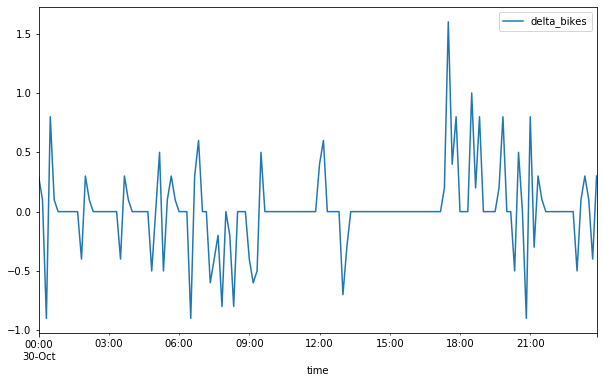

In [37]:
# some code for inspection
stationID = 84
interval = 10
interval_status_df = status_df[status_df.station_id==stationID].drop('station_id', axis=1)
interval_status_df = interval_status_df.resample(f"{interval}T", on = 'time').mean().reset_index()

delta_df = pd.DataFrame()
delta_df['time'] = interval_status_df['time'].shift(-1)
delta_df['delta_bikes'] = (interval_status_df['bikes_available'].shift(-1) - interval_status_df['bikes_available'])
delta_df.dropna(inplace=True)

delta_df = delta_df.set_index('time')
delta_df.loc['2014-10-30'].plot(figsize=(10,6))